In [1]:
from skimage import feature, color, filters, measure, io
import cv2
import numpy as np
from scipy.ndimage import distance_transform_edt

import matplotlib.pyplot as plt
from scipy import ndimage as nd
from skimage.color import label2rgb
import pandas as pd

# Localiszation of plants on the tray

In [2]:
#Image path
img=io.imread('/home/mcaroulle/Pheno_Leaf/Data/Color segmentation/TRAY_1.png')
#plt.imshow(img)

##convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask= cv2.inRange(hsv,(30,20,150),(70,255,255))

closed_mask = nd.binary_closing(mask, np. ones ((7,7)))

label_image= measure.label(closed_mask)

#image_label_overlay = label2rgb(label_image, image= img)
#plt.imshow(image_label_overlay)

props = measure.regionprops_table(label_image, img, 
                                  properties=['label','area','centroid','coords'])

df = pd.DataFrame(props)
#print(df.head())

### Remove border artefacts

In [3]:
from skimage import segmentation

# remove artifacts connected to image border
cleared_label_image = segmentation.clear_border(label_image)

#take measurements 
props = measure.regionprops_table(cleared_label_image, img,
                                  properties=['label', 'area', 'centroid','coords'])

# Convert props to DataFrame
df = pd.DataFrame(props)

### Filtering by area

In [4]:
# Filter regions with area less than 5,000
df_filtered = df[df['area'] >= 500]

# Filter label_image based on the filtered DataFrame
filtered_label_image = np.isin(cleared_label_image , df_filtered['label'])

### NOT RELEVANT STILL NOISE

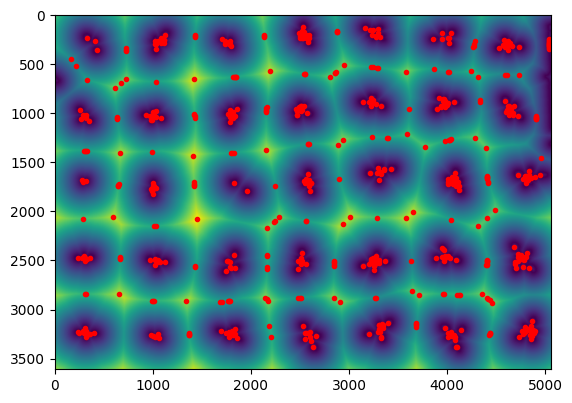

In [5]:
###On définit une fonction qui permet de convertir un masque en une image
def convertir_masque_en_image(mask):
    # Créer une image vide avec les mêmes dimensions que le masque
    image = np.zeros_like(mask)

    # Appliquer le masque à l'image en définissant les pixels blancs
    image[mask > 0] = 255

    # Enregistrer l'image
    return image

image = convertir_masque_en_image(filtered_label_image)

edges = feature.canny(image, sigma=10)

dt = distance_transform_edt(~edges)

local_max = feature.peak_local_max(dt, min_distance=5)

peak_idx = feature.peak_local_max(dt, min_distance=5)

plt.plot(peak_idx[:,1],peak_idx[:,0],'r.')
plt.imshow(dt)

# Creating plants by merging leaves

#### Generate a dataframe with peaks coords

In [6]:
df_peak = pd.DataFrame(peak_idx)
df_peak.columns=['x_coord','y_coord']
df_peak['index_of_label_in_df_coords']=''
df_peak['label']=''

#### Generate a dataframe with label coords

In [7]:
df_filtered_reinit=df_filtered.reset_index(drop=True) #reset of indexes

df_coords=df_filtered_reinit[['label','coords']]

In [8]:

for k in range(len(df_coords)): 
    
    data_coords = df_coords['coords'][k] #array
    coords = data_coords.tolist() #list of list
    x_coords = [sous_liste[0] for sous_liste in coords] #list
    y_coords = [sous_liste[1] for sous_liste in coords] #list 

    # Parcourir les lignes du dataframe
    for index, row in df_peak.iterrows():
        if row['x_coord'] in x_coords and row['y_coord'] in y_coords:
            df_peak.at[index, 'index_of_label_in_df_coords'] = k
        
#Nettoyage du dataframe obtenu
df_peak = df_peak[df_peak['index_of_label_in_df_coords'] != '']

# Recherche des valeurs en double dans la colonne 3
valeurs_en_double = df_peak[df_peak.duplicated(subset='index_of_label_in_df_coords', keep=False)]['index_of_label_in_df_coords'].unique()

# Suppression des lignes en double, sauf la première occurrence
df_peak = df_peak.drop_duplicates(subset='index_of_label_in_df_coords', keep='first')

    

In [9]:
for k in df_peak['index_of_label_in_df_coords']: 
    # Extraction de l'élément de la colonne1 à partir de l'indice
    element = df_coords.loc[k, 'label']

    # Retrouver l'index de la ligne contenant l'élément dans la colonne 3
    index = df_peak.loc[df_peak['index_of_label_in_df_coords'] == k].index[0]

    # Ajouter l'élément dans la ligne donnée de la colonne 3
    df_peak.at[index, 'label'] = element

#### Generate a data-frame for pots

In [ ]:
from skimage.io import imread
import pandas as pd

# Charger l'image
image = imread('/home/mcaroulle/Pheno_Leaf/Data/Color segmentation/TRAY_1.png')

# Extraire les dimensions de l'image
height, width, channels = image.shape

#Calcul de la largeur et de la hauteur des pots dans le tray
x_pot = width/7
y_pot = height/5



# Création des données qui correspond à un découpage du tray en pots
x_min=[]
x_max=[]
X=[]

for k in range(5):
    x=0
    for k in range (8):
        X.append(int(x))
        x+=x_pot
    x_min+=X[0:7]
    x_max+=X[1:8]
    if x_max[-1]!=width:
        x_max[-1]=width


y_min=[]
y_max=[]
Y=[]


for k in range(7):
    y=0
    for k in range (6):
        Y.append(int(y))
        y+=y_pot
    y_min+=Y[0:5]
    y_max+=Y[1:6]
    if y_max[-1]!=height:
        y_max[-1]=height


data_tray_max = {'Pot_position': [i for i in range(1, 36)],
        'xmin': [k for k in x_min],
        'xmax': [k for k in x_max],
        'ymin': [k for k in y_min],
        'ymax': [k for k in y_max]}

df_tray_max = pd.DataFrame(data_tray_max)
#print(df_tray_max)


##Opération sur df_tray_max pour créer df_tray_min

#Calculation of the rejected zone
x_R_pot = int((width/7)/20)
y_R_pot = int((height/5)/20)


df_tray_min = pd.DataFrame(data_tray_max)


df_tray_min['xmin'] = df_tray_min['xmin'] + x_R_pot
df_tray_min['xmax'] = df_tray_min['xmax'] - x_R_pot
df_tray_min['ymin'] = df_tray_min['ymin'] + y_R_pot
df_tray_min['ymax'] = df_tray_min['ymax'] - y_R_pot

#### Clean the initial dataframe by removing all objects that are not leaves

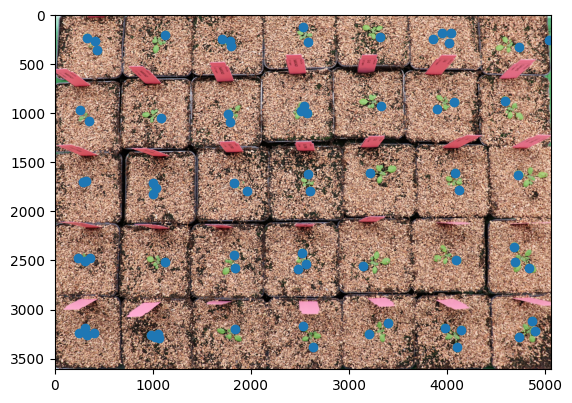

In [10]:
df_peak_label=pd.merge(df_filtered_reinit, df_peak, on='label', how='inner')
df_peak_label = df_peak_label.rename(columns={'x_coord' : 'y_coord' , 'y_coord' : 'x_coord'})
x = df_peak_label['x_coord']
y = df_peak_label['y_coord']
plt.imshow(img)
plt.scatter(x,y)
plt.show()

# STOP

#### Assign leaves in pots and merge them to form a plant

In [ ]:
Labels_to_fuse=[]

for k in range (len(df_tray_min)): #on lit les pots 1 par 1 
    #### PEAKS PRESENTS DANS LE TRAY MIN
    
    df_peak_in_pot= df_peak_label[(df_peak_label['x_coord'] >= df_tray_min['xmin'][k]) & (df_peak_label['x_coord'] <= df_tray_min['xmax'][k]) & (df_peak_label['y_coord'] >= df_tray_min['ymin'][k]) & (df_peak_label['y_coord'] <= df_tray_min['ymax'][k])]

    Labels_to_fuse.append((df_peak_in_pot['label'].values).tolist())

len(Labels_to_fuse)
#Lables_to_fuse is a list of list

#little cleaning of the list
#for k in Labels_to_fuse:
    # while k.count('nan')>0:
        # k.pop('nan')

print(Labels_to_fuse)

# Image reconstruction

In [ ]:
#Here we define a function wich allow to merge the labels in an image
def merge_labels(label_image, list_labels):

    for k in range (len(list_labels)-1):
        merged_label_image = np.copy(label_image)
        merged_label_image[merged_label_image == list_labels[k+1]] = list_labels[k]

    return merged_label_image

'''for k in Labels_to_fuse:
    print(k)
    print(len(k))
    if len(k)>1:
        merge_labels(filtered_label_image,k)

'''



data_iteresting_label= data_tray_max ={'label': [i[0] for i in Labels_to_fuse]}
df_iteresting_label = pd.DataFrame(data_iteresting_label)


# Filter label_image based on the filtered DataFrame
filtered_label_image = np.isin(merged_label_image, df_iteresting_label['label'])

image_label_overlay = label2rgb(filtered_label_image, image= img)
plt.imshow(image_label_overlay)



#props = measure.regionprops_table(filtered_label_image, img, 
 #                                properties=['label'])

#final = pd.DataFrame(props)

#image_label_overlay = label2rgb(filtered_label_image, image= img)
#plt.imshow(image_label_overlay)

In [ ]:
nouveau_label[nouveau_label.index(label)]